In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt

sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

import seaborn as sns

Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [2]:
df_bonds = make_dataset.read_pkl('bonds')

2022-01-27 21:43:05.454 | INFO     | src.data.make_dataset:read_pkl:352 - Load preprocessed bonds data


In [3]:
df_bonds.head()

,ccy,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
0,EUR,Netherlands,Nederland 4.00% 09-2019,2009-02-13,2009-07-15,2019-07-15,NL0009086115,STAAT DER NEDERLANDEN,ANNUAL,4.00000,5000.00000,DBFTFN,AAA,3804
1,NLG,Austria,Austria 6.25% 94-2024,1994-02-28,1995-02-28,2024-02-28,NL0000133924,AUSTRIA,ANNUAL,6.25000,1000.00000,DBFTXB,AA+,10957
2,EUR,Netherlands,Nederland 2.50% 12-2033,2012-03-09,2013-01-15,2033-01-15,NL0010071189,STAAT DER NEDERLANDEN,ANNUAL,2.50000,4160.00000,DBFXXN,AAA,7617
5,USD,United States,US GOVT 6.125% 99-2029,1999-08-15,1999-08-15,2029-08-15,US912810FJ26,UNITED STATES TREASURY,SEMI ANNUAL,6.12500,11179.00000,DBFTFR,AAA,10958
7,USD,United States,US GOVT 6.250% 00-2030,2000-02-15,2000-05-15,2030-05-15,US912810FM54,UNITED STATES TREASURY,SEMI ANNUAL,6.25000,17043.00000,DTFTFR,AAA,11047


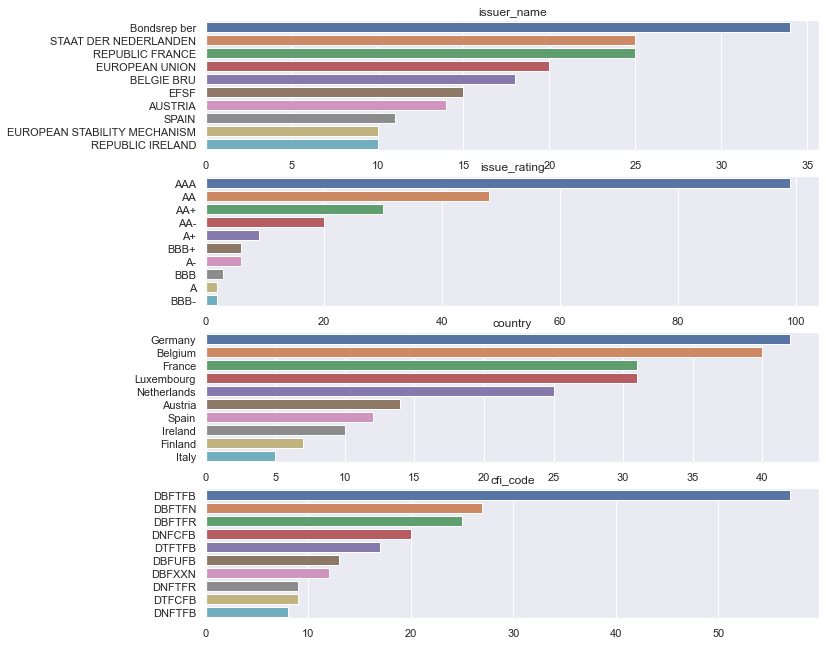

In [4]:
sns.set(rc={'figure.figsize':(11,11)})
visualize.countplot(data = df_bonds, x = ['issuer_name', 'issue_rating','country','cfi_code'], subplots = True, ncols = 1, other_category = True)

Bond prices

In [5]:
df_price = make_dataset.read_pkl('price')
df_price.head()

2022-01-27 21:43:16.477 | INFO     | src.data.make_dataset:read_pkl:352 - Load preprocessed price data


,reference_identifier,ccy,rate_dt,mid,lastday
0,DE0001135143,EUR,2010-12-17,136.76000,2010-12-31
1,NL0000102275,EUR,2010-12-17,103.39000,2010-12-31
2,DE0001135424,EUR,2010-12-17,95.45300,2010-12-31
3,NL0009446418,EUR,2010-12-17,102.69000,2010-12-31
4,NL0000102234,EUR,2010-12-17,106.22000,2010-12-31


Laten we eerst kijken naar de distributie van de bondprijzen. De meeste bonds zijn boven par (100) geprijst. Dat klinkt logisch in een wereled waar al geruime tijd de lange termijn rente daalt. De waarde van 'oudere' bonds stijgt hierdoor.

<AxesSubplot:xlabel='Prijs', ylabel='Aantal'>

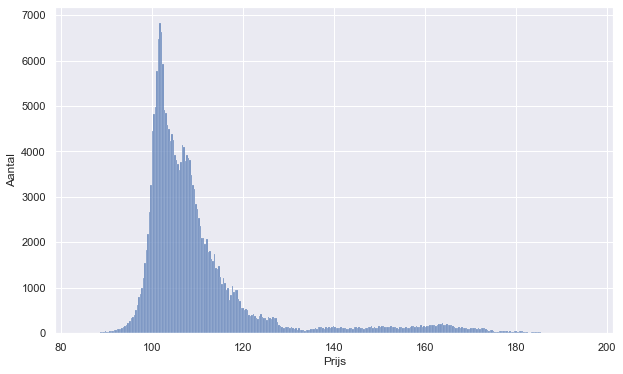

In [6]:
visualize.distribution(df_price,x = 'mid')

Voor het onderzoek richten we ons in eerste instantie op Nederlandse staatsobligaties met een looptijd van 10 jaar. Voor bijna ieder jaar is er een uitgifte van een 10 jaars vastrente obligatie. 

In [7]:
df_bp = make_dataset.read_pkl('bp')

2022-01-27 21:50:46.754 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed bp data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

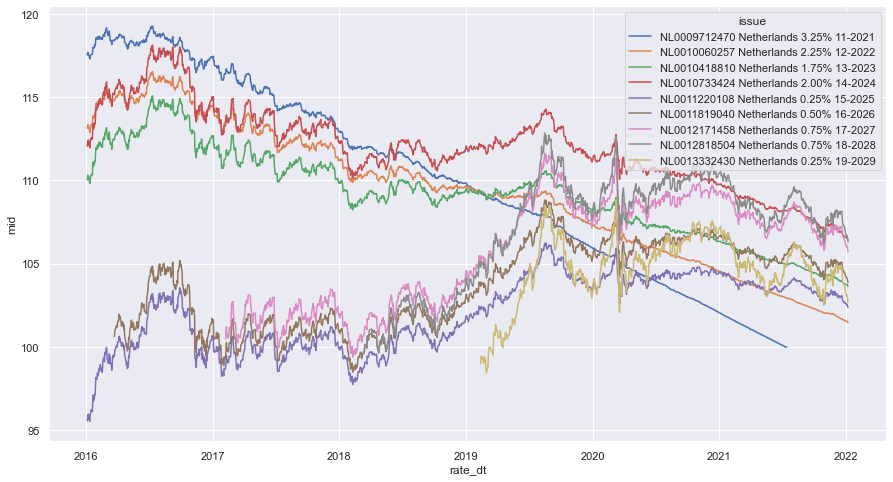

In [12]:
# Select 10 year NL bonds, data from 2016

df_bp_10y = df_bp.loc[( df_bp['bond_duration'] > 3650 ) & ( df_bp['bond_duration'] < 4000 )]
df_bp_10y = df_bp_10y.sort_values( by = ['country','mature_dt'] )

filter =    ( df_bp_10y['country'] == 'Netherlands' ) & \
            ( df_bp_10y['coupon'] > 0 ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2016' )       
df_nl_10y = df_bp_10y.loc[filter]

visualize.lineplot(data = df_nl_10y, x = 'rate_dt', y = 'mid', hue = 'issue', figsize=(15,8))

We zien dat de bond prijs gerelateerd is aan de hoogte van de coupon en de resterende looptijd. 
We zien bij alle bonds dat de prijs de laatste 5 jaar ongeveer gelijkmatig terugloopt naar 100 naarmate de eind datum van de bond dichterbij komt.

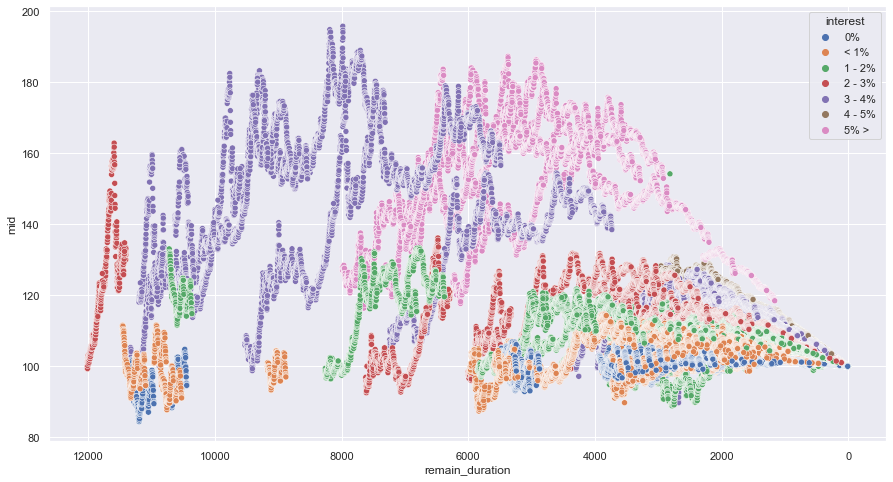

In [17]:
df_bp =df_bp.assign(interest = pd.cut(df_bp["coupon"], [-1,0.001,1,2,3,4,5,10], 
                        labels=['0%', '< 1%', '1 - 2%','2 - 3%', '3 - 4%','4 - 5%', '5% >']))
ax = visualize.scatterplot(data = df_bp, x = 'remain_duration', y = 'mid', hue = 'interest', figsize=(15,8))
ax.invert_xaxis()

<AxesSubplot:xlabel='interest', ylabel='mid'>

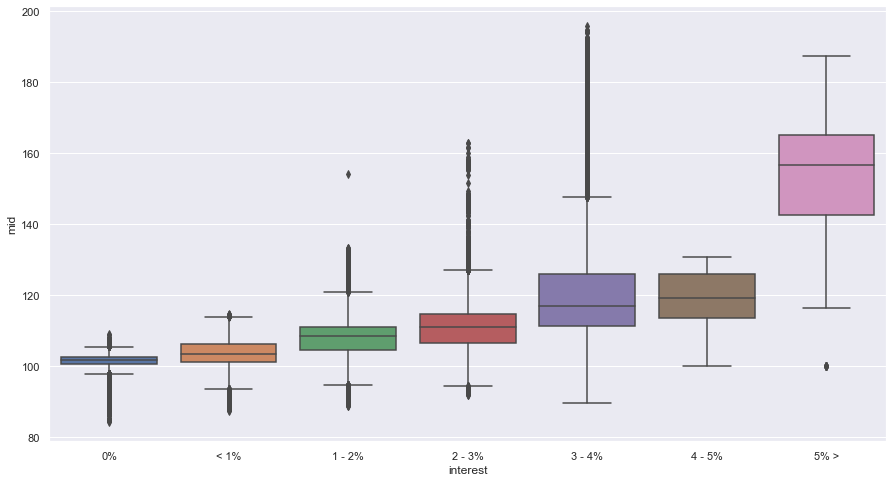

In [33]:
visualize.boxplot(data = df_bp, x= 'interest', y = 'mid', figsize=(15,8))

We kunnen ook bonds vergelijken met een zelfde resterende looptijd. Het koersverloop wordt dan met name verklaard door het kredietrisico van de issuer en de coupon rente. 

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

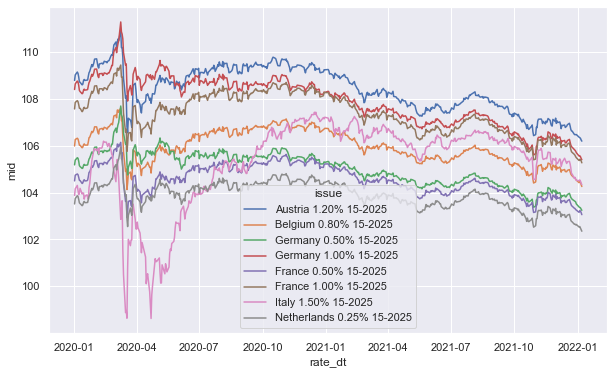

In [34]:
df_mature_2025 = df_bp.loc[( df_bp['mature_dt'].dt.year == 2025 )]
filter =    ( df_mature_2025['coupon'] > 0 ) & \
            ( df_bp_10y['rate_dt'] > '1-jan-2020' )                            
df_mature_2025 = df_mature_2025.loc[filter]
df_mature_2025['issue'] = df_mature_2025['country'] + ' ' + df_mature_2025['bond_ext_name'].str.split(n=1).str[1]

visualize.lineplot(data = df_mature_2025, x = 'rate_dt', y = 'mid', hue = 'issue')

De rating van de bond lijkt niet veel invloed te hebben op de bondprijs.


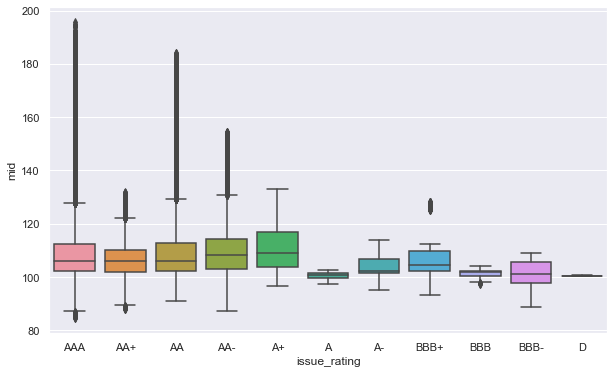

In [35]:
ax = visualize.boxplot(data = df_bp, x= 'issue_rating', y = 'mid', order=["AAA", "AA+","AA","AA-","A+","A","A-","BBB+","BBB","BBB-","D"])

# Yield Curve

De yield curve wordt samengesteld door de prijzen van government bonds met verschillende maturities samen te voegen en te extrapoleren.

2022-01-27 22:15:30.028 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

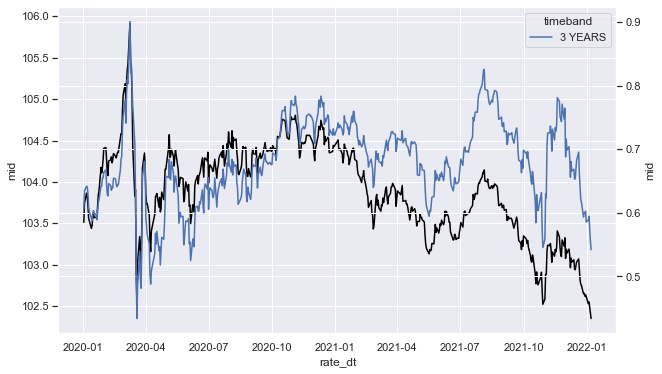

In [36]:

df_yield = make_dataset.read_pkl('yield')
df_yield = df_yield[df_yield['rate_dt']>='1-jan-2020']
df_yield_nl = df_yield[df_yield['country']=='Netherlands']
# Our bond has a remaining duration of aprox 3 years - compare with 3 years yield
df_yield_nl = df_yield_nl[df_yield_nl['timeband'].isin(['3 YEARS'])]

df = df_bp[df_bp['isin'] == "NL0011220108"]
df = df[df['rate_dt'] >= '1-jan-2020']
sns.lineplot(data = df, x = 'rate_dt', y = 'mid',color = 'black')
df_yield_nl['mid'] = df_yield_nl['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_yield_nl, x = 'rate_dt', y = 'mid', hue = 'timeband', ax=ax2)


Een van de features die vanuit de literatuur wordt aangedragen is de 'term spread'. Dit is het verschil tussen korte en lange rente. We zien in onderstaand plaatje dat het verschil in korte en langer rente tot 2019 terug liep.

2022-01-27 22:15:40.392 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed yield data


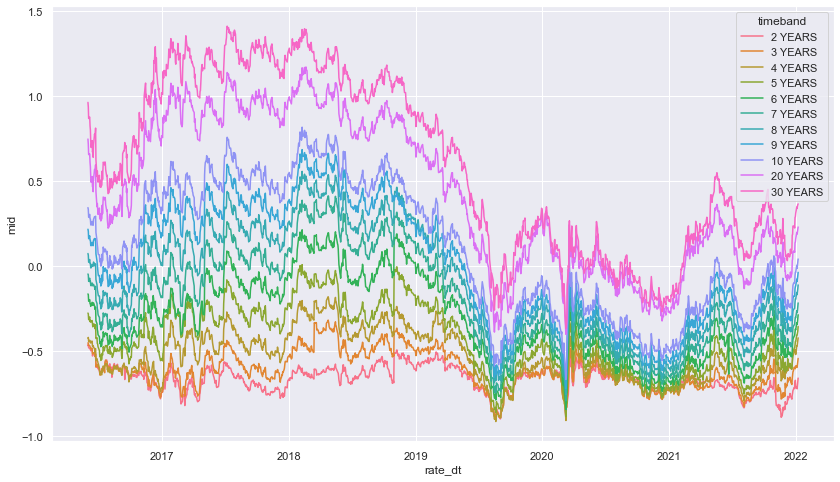

In [37]:
df_yield = make_dataset.read_pkl('yield')
df_yield = df_yield[df_yield['rate_dt'] > '1-jan-2016']

country = 'Netherlands'
df_country = df_yield[df_yield['country']==country]

plt.figure(figsize=(14, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'mid',hue = 'timeband', hue_order=hue_order)

Credit Spread

Inflation

De rente is theoretisch gecorreleerd aan de inflatie verwachting. In de praktijk is deze correlatie niet altijd evident. Ook is het niet duidelijk of de bondprijzen worden gevormd door de lnflatieverwachting, of omgekeerd de inflatie wordt afgeleid uit stijgende prijzen voor staatsobligaties.

2022-01-27 22:16:33.768 | INFO     | src.data.make_dataset:read_pkl:356 - Load preprocessed inflation data


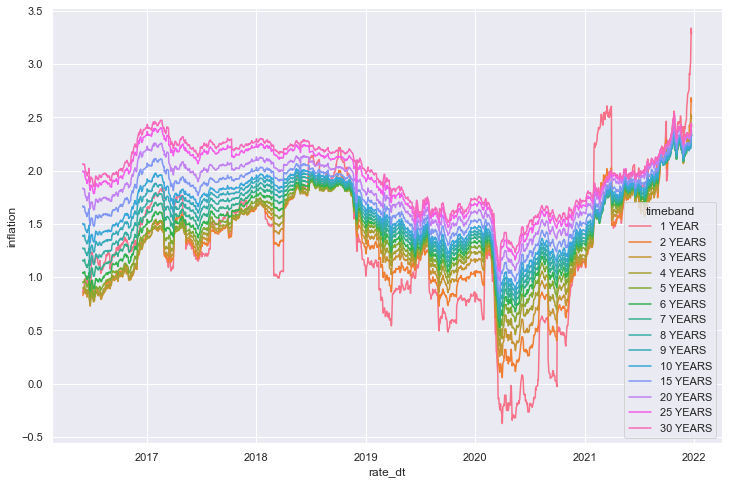

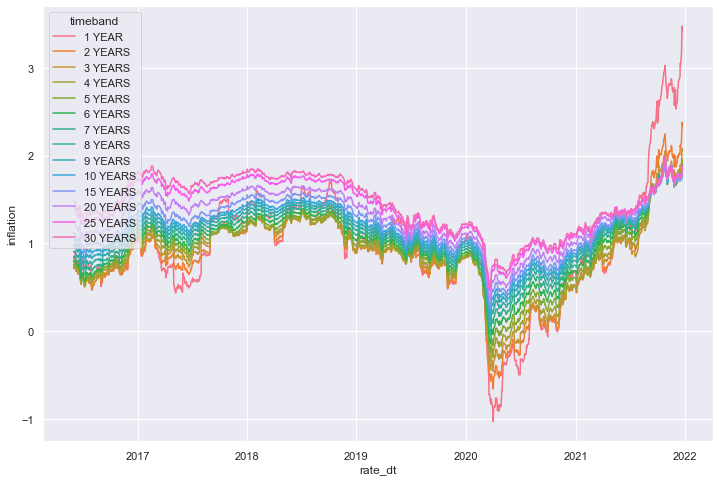

In [38]:

df_inflation = make_dataset.read_pkl('inflation')
df_inflation = df_inflation[df_inflation['rate_dt'] > df_yield['rate_dt'].min()]

country = 'Germany'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

country = 'Italy'
df_country = df_inflation[df_inflation['country']==country]

plt.figure(figsize=(12, 8))
hue_order = sorted(df_country['timeband'].unique(), key = lambda x: int(x[0:2]))
ax = sns.lineplot(data = df_country, x = 'rate_dt', y = 'inflation', hue = 'timeband', hue_order=hue_order)

Inflatie zou een negatieve correlatie moeten hebben met de bond prijs. 